In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/cleaned_indian_property_2.csv'

df = pd.read_csv(file_path, encoding="latin1")

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

# Boosters
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
df.columns = df.columns.str.strip().str.lower()
print("Loaded:", df.shape)


Loaded: (320020, 31)


In [ ]:
for col in ["price_num", "area_num", "price_per_sqft"]:
    if col not in df.columns:
        print("Warning:", col, "not found")

# create bhk numeric if needed
if "bhk" not in df.columns:
    if "no_of_bhk" in df.columns:
        df["bhk"] = df["no_of_bhk"].astype(str).str.extract(r'(\d+)').astype(float)
df = df[df["bhk"].notnull() & (df["bhk"] > 0)]

In [ ]:
# coerce core numerics
df["area_num"] = pd.to_numeric(df["area_num"], errors="coerce")
df["price_num"] = pd.to_numeric(df["price_num"], errors="coerce")
df = df.dropna(subset=["area_num", "price_num"])

# ---------- 4. High-value feature engineering ----------
# price per sqft (if not present)
if "price_per_sqft" not in df.columns:
    df["price_per_sqft"] = df["price_num"] / df["area_num"]

# basic derived features
df["price_per_bhk"] = df["price_num"] / df["bhk"]
df["area_per_bhk"] = df["area_num"] / df["bhk"]

In [ ]:
if "bath" in df.columns:
    df["bath"] = pd.to_numeric(df["bath"], errors="coerce").fillna(df["bhk"])
else:
    df["bath"] = df["bhk"]  # fallback
df["price_per_bath"] = df["price_num"] / (df["bath"] + 1)

# demand density (listings per locality)
if "locality_name" in df.columns:
    locality_counts = df["locality_name"].value_counts().to_dict()
    df["demand_density"] = df["locality_name"].map(locality_counts).fillna(0).astype(int)
else:
    df["demand_density"] = 0


In [ ]:
if "locality_name" in df.columns:
    local_mean = df.groupby("locality_name")["price_per_sqft"].transform("mean")
    df["price_dev_locality"] = df["price_per_sqft"] - local_mean
else:
    df["price_dev_locality"] = 0

# luxury index
if all(c in df.columns for c in ["bath","bhk","is_furnished","listing_domain_score"]):
    # normalize is_furnished to 0/1 first
    df["is_furnished"] = df["is_furnished"].astype(str).str.lower().map(
        {"furnished":1,"unfurnished":0,"semi-furnished":0}).fillna(0).astype(int)
    df["luxury_index"] = (df["bath"]/df["bhk"]).fillna(0) + df["is_furnished"] + df["listing_domain_score"].fillna(0)
else:
    df["luxury_index"] = 0

# normalized area category
df["area_cat"] = pd.cut(df["area_num"], bins=[0,1000,2000,1e9], labels=["small","medium","large"])

# distance_from_city_center via approximate city centers if lat/lon present
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

city_centers = {
    "bangalore": (12.9716, 77.5946),
    "mumbai": (19.0760, 72.8777),
    "delhi": (28.6139, 77.2090),
    "chennai": (13.0827, 80.2707),
    "hyderabad": (17.3850, 78.4867),
    "kolkata": (22.5726, 88.3639),
    "lucknow": (26.8467, 80.9462)
}
if "latitude" in df.columns and "longitude" in df.columns:
    df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
    df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
    def compute_dist(row):
        city = str(row.get("city_name","")).lower()
        lat = row["latitude"]; lon = row["longitude"]
        for k,(clat,clon) in city_centers.items():
            if k in city:
                return haversine_km(lat, lon, clat, clon)
        return np.nan
    df["dist_city_center"] = df.apply(lambda r: compute_dist(r) if pd.notna(r["latitude"]) and pd.notna(r["longitude"]) else np.nan, axis=1)
else:
    df["dist_city_center"] = np.nan

# optional: fill NA distances with median
df["dist_city_center"] = df["dist_city_center"].fillna(df["dist_city_center"].median())

print("Features engineered. Shape:", df.shape)

Features engineered. Shape: (231029, 41)


In [ ]:
base_feats = ["area_num","bhk","listing_domain_score","is_furnished","is_rera_registered","is_apartment",
              "price_per_bhk","area_per_bhk","price_per_bath","demand_density","price_dev_locality",
              "luxury_index","dist_city_center"]

# one-hot encode area_cat and top-k localities or cities
# keep top 20 localities; rest -> other
if "locality_name" in df.columns:
    top_localities = df["locality_name"].value_counts().nlargest(20).index
    df["locality_top"] = df["locality_name"].where(df["locality_name"].isin(top_localities), "other")
    cat_locality = pd.get_dummies(df["locality_top"], prefix="loc", drop_first=True)
    df = pd.concat([df, cat_locality], axis=1)
    loc_cols = cat_locality.columns.tolist()
else:
    loc_cols = []

In [ ]:
area_cat_dummies = pd.get_dummies(df["area_cat"], prefix="area_cat", drop_first=True)
df = pd.concat([df, area_cat_dummies], axis=1)

# city dummies (top cities)
if "city_name" in df.columns:
    top_cities = df["city_name"].value_counts().nlargest(10).index
    df["city_top"] = df["city_name"].where(df["city_name"].isin(top_cities), "other")
    city_dummies = pd.get_dummies(df["city_top"], prefix="city", drop_first=True)
    df = pd.concat([df, city_dummies], axis=1)
    city_cols = city_dummies.columns.tolist()
else:
    city_cols = []

# final feature list
features = base_feats + loc_cols + city_cols + area_cat_dummies.columns.tolist()
# keep only existing columns
features = [c for c in features if c in df.columns]
print("Final features count:", len(features))

Final features count: 42


In [ ]:
X = df[features].fillna(0)   # small fill; change strategy if needed
y = df["price_num"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/test:", X_train.shape, X_test.shape)

# ---------- 7. Scaling for meta learner (we will scale when needed) ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------- 8. Baseline models: Linear, RF, LGBM, XGB ----------
print("Training baseline models (use smaller n_estimators if CPU slow)...")
lr = Ridge(alpha=1.0)
rf = RandomForestRegressor(n_estimators=150, max_depth=20, n_jobs=-1, random_state=42)
lgb = LGBMRegressor(n_estimators=300, learning_rate=0.05, n_jobs=-1, random_state=42)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=8, n_jobs=-1, tree_method='hist', random_state=42)

# fit (you can comment out some fits to save time while experimenting)

Train/test: (184823, 42) (46206, 42)
Training baseline models (use smaller n_estimators if CPU slow)...


In [ ]:
lr.fit(X_train_scaled, y_train)            # ridge on scaled features
rf.fit(X_train, y_train)
lgb.fit(X_train, y_train, eval_set=[(X_test,y_test)])
xgb.fit(X_train, y_train, eval_set=[(X_test,y_test)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2015
[LightGBM] [Info] Number of data points in the train set: 184823, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 14221181.897129
[0]	validation_0-rmse:18086493.71706
[1]	validation_0-rmse:17193699.23523
[2]	validation_0-rmse:16345269.56440
[3]	validation_0-rmse:15539640.32526
[4]	validation_0-rmse:14774289.56169
[5]	validation_0-rmse:14046844.40511
[6]	validation_0-rmse:13356311.72794
[7]	validation_0-rmse:12698741.65024
[8]	validation_0-rmse:12073591.65347
[9]	validation_0-rmse:11481927.81227
[10]	validation_0-rmse:10919056.90967
[11]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
def eval_preds(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:,.0f}, RMSE={rmse:,.0f}, R2={r2:.4f}")
    return {"mae":mae,"rmse":rmse,"r2":r2}

In [ ]:
print("Baseline results:")
res_lr = eval_preds("Ridge", y_test, lr.predict(X_test_scaled))
res_rf = eval_preds("RandomForest", y_test, rf.predict(X_test))
res_lgb = eval_preds("LightGBM", y_test, lgb.predict(X_test))
res_xgb = eval_preds("XGBoost", y_test, xgb.predict(X_test))

Baseline results:
Ridge: MAE=1,467,039, RMSE=2,493,371, R2=0.9828
RandomForest: MAE=7,243, RMSE=194,721, R2=0.9999
LightGBM: MAE=132,501, RMSE=608,304, R2=0.9990
XGBoost: MAE=120,034, RMSE=941,444, R2=0.9976


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define model results
data = {
    "Model": ["Ridge Regression", "Random Forest", "LightGBM", "XGBoost"],
    "MAE": [1467039, 7243, 132501, 120034],
    "RMSE": [2493371, 194721, 608304, 941444],
    "R2 (%)": [98.28, 99.99, 99.90, 99.76]
}

# Create DataFrame
results_df = pd.DataFrame(data)


In [ ]:
print("Model Performance Comparison:\n")
print(results_df.to_string(index=False))

Model Performance Comparison:

           Model     MAE    RMSE  R2 (%)
Ridge Regression 1467039 2493371   98.28
   Random Forest    7243  194721   99.99
        LightGBM  132501  608304   99.90
         XGBoost  120034  941444   99.76


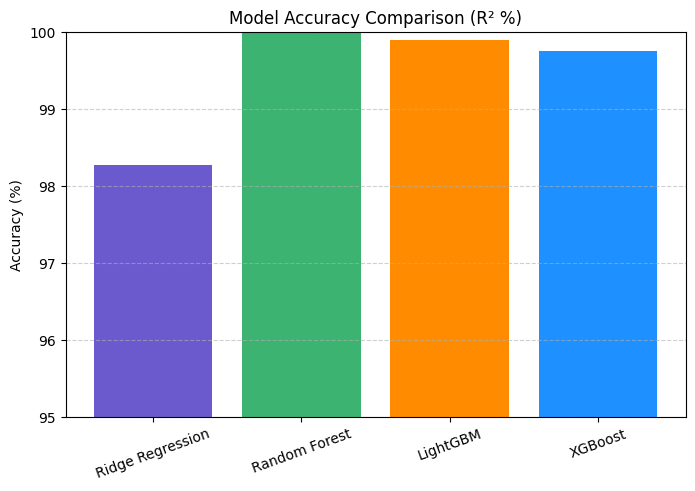

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["R2 (%)"], color=["#6A5ACD","#3CB371","#FF8C00","#1E90FF"])
plt.title("Model Accuracy Comparison (R² %)")
plt.ylabel("Accuracy (%)")
plt.ylim(95, 100)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
from sklearn.linear_model import RidgeCV
estimators = [
    ('rf', RandomForestRegressor(n_estimators=150, max_depth=20, n_jobs=-1, random_state=42)),
    ('lgb', LGBMRegressor(n_estimators=300, learning_rate=0.05, n_jobs=-1, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=8, n_jobs=-1, tree_method='hist', random_state=42))
]

In [ ]:
import matplotlib.pyplot as plt
imp = pd.Series(lgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top features:\n", imp.head(15))

Top features:
 bhk                   2190
price_per_bath        2071
price_per_bhk         1317
area_num               754
dist_city_center       681
demand_density         622
area_per_bhk           602
price_dev_locality     575
city_Mumbai             48
city_Delhi              38
is_furnished            26
is_apartment            25
is_rera_registered      23
luxury_index            10
city_Bangalore           8
dtype: int32


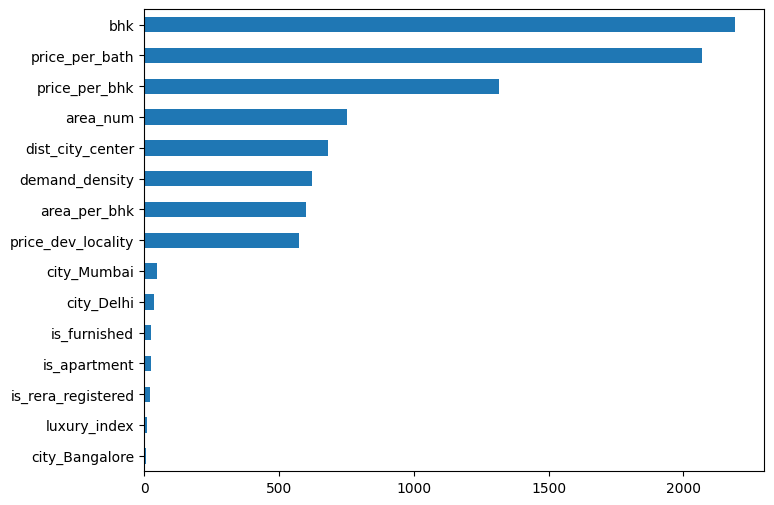

In [ ]:
imp.head(15).plot(kind='barh', figsize=(8,6)); plt.gca().invert_yaxis(); plt.show()